### Note: Before running the code, make sure to amend the CPU/GPU information in the supporting files as per machine requirement

In [1]:
# For Data Extraction and Class Creation
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import torch 
import json

# For Training
import torchvision
from engine import train_one_epoch, evaluate
import utils

# For Testing
import random

# Image Data Extraction and Class Creation

In [4]:
# Creating Class for Data Extraction and Processing

class OCRDataset(torch.utils.data.Dataset):
    
    def __init__(self, root):

        self.root = root
#         self.transforms = transforms
        
        # Load the image files, note that this is done only to get length of the number of files in our root directory
        self.imgs = list(os.listdir(root))[:-1]
        
        # Load the JSON file containing the data
        self.data = json.load(open(os.path.join(self.root, 'result.json')))
        
    def __getitem__(self, idx):
        
        # Load Images
        image_id = self.data['images'][idx]['id']
        image_path = self.data['images'][idx]['file_name'][10:]

        # Extracting the image from the file path
        image = Image.open(os.path.join(self.root, image_path)).convert('RGB')

        # Extracting the image information from the JSON file except MASK
        target = {}
        target['boxes'] = self.data['annotations'][idx]['bbox']
        target['labels'] = self.data['annotations'][idx]['category_id']+1
        target['image_id'] = self.data['annotations'][idx]['image_id']
        target['area'] = self.data['annotations'][idx]['area']
        target['iscrowd'] = self.data['annotations'][idx]['iscrowd']
        
        pts = np.array([[int(self.data['annotations'][idx]['segmentation'][0][0]), int(self.data['annotations'][idx]['segmentation'][0][1])],\
                        [int(self.data['annotations'][idx]['segmentation'][0][2]), int(self.data['annotations'][idx]['segmentation'][0][3])],\
                        [int(self.data['annotations'][idx]['segmentation'][0][4]), int(self.data['annotations'][idx]['segmentation'][0][5])],\
                        [int(self.data['annotations'][idx]['segmentation'][0][6]), int(self.data['annotations'][idx]['segmentation'][0][7])]])
        
        xSorted = pts[np.argsort(pts[:,0]),:]
        
        leftMost = xSorted[:2,:]
        rightMost = xSorted[2:,:]
        
        leftMost = leftMost[np.argsort(leftMost[:,1]), :]
        (tl, bl) = leftMost
        
        D = dist.cdist(tl[np.newaxis], rightMost, 'euclidean')[0]
        (br, tr) = rightMost[np.argsort(D)[::-1], :]
        
        target['keypoints'] = np.array([[max(tl[0],0), max(tl[1],0),1],
                                        [max(tr[0],0), max(tr[1],0),1],
                                        [max(br[0],0), max(br[1],0),1],
                                        [max(bl[0],0), max(bl[1],0),1]])
        
#         # Initiating the Mask
#         mask = np.zeros([self.data['images'][idx]['height'], self.data['images'][idx]['width']])

#         # Processing for Masking
#         r = np.array([self.data['annotations'][idx]['segmentation'][0][1], self.data['annotations'][idx]['segmentation'][0][3], self.data['annotations'][idx]['segmentation'][0][5], self.data['annotations'][idx]['segmentation'][0][7]])
#         c = np.array([self.data['annotations'][idx]['segmentation'][0][0], self.data['annotations'][idx]['segmentation'][0][2], self.data['annotations'][idx]['segmentation'][0][4], self.data['annotations'][idx]['segmentation'][0][6]])
#         rr, cc = polygon(r, c)
        
#         try:
#             # Masking the Image
#             mask[rr-1, cc-1] = 1
#         except:
#             mask[rr-3, cc-3] = 1

#         target['masks'] = mask
        
#         # Converting the negative coordinates to Zero
#         target['boxes'] = [0 if i < 0 else i for i in target['boxes']]

        # Calculating the (x1,y1) and (x2,y2) of the bounding boxes from width and height
        target['boxes'] = [target['boxes'][0], target['boxes'][1], target['boxes'][0]+target['boxes'][2], target['boxes'][1]+target['boxes'][3]]
        
        # Reshaping
        target['boxes'] = np.expand_dims(target['boxes'], axis=0)
#         target['masks'] = np.expand_dims(target['masks'], axis=0)

        # Converting all arrays to tensors for compatibility with PyTorch
        target['boxes'] = torch.as_tensor(target['boxes'], dtype=torch.float32)
        target['labels'] = torch.tensor([target['labels']], dtype=torch.int64)
#         target['masks'] = torch.as_tensor(target['masks'], dtype=torch.uint8)
        target['image_id'] = torch.tensor([target['image_id']])
        target['area'] = torch.tensor([target['area']])
        target['iscrowd'] = torch.tensor([target['iscrowd']], dtype=torch.int64)
        target['keypoints'] = torchl.tensor([target['keypoints']], dtype=torch.float32)

#         if self.transforms is not None:
#             image, target = self.transforms(image, target)

        return image, target
            
    def __len__(self):
        return len(self.imgs)

In [6]:
# Defining direcotries and loading the json file
root = 'C:/Users/muhammad.ispahani/Desktop/Data Science Project/CNIC OCR/Segmentation/All Labeled/images'
json_file = 'C:/Users/muhammad.ispahani/Desktop/Data Science Project/CNIC OCR/Segmentation/All Labeled/images/result.json'
data = json.load(open(json_file))

In [13]:
x = OCRDataset(root=root, transforms=None)
img, target = x.__getitem__(1000)

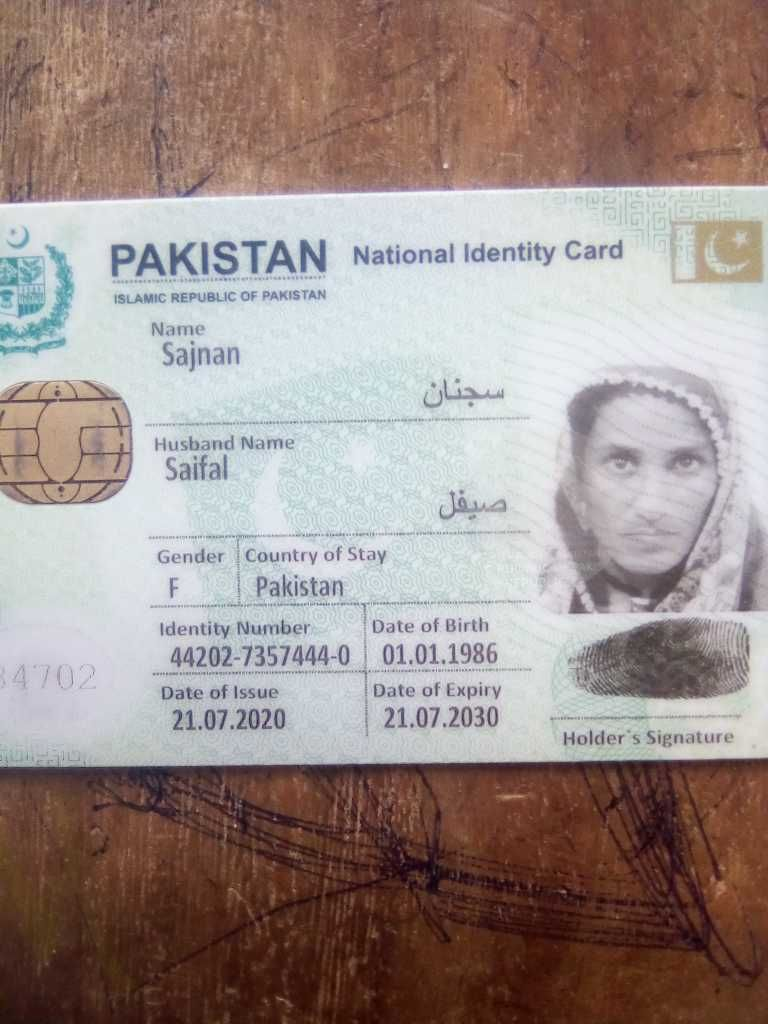

In [14]:
img

In [15]:
target

{'boxes': tensor([[  0.0000, 183.2960, 763.9040, 765.9520]]),
 'labels': tensor([3]),
 'image_id': tensor([1000]),
 'area': tensor([432978.]),
 'iscrowd': tensor([0]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)}

# Model Training

In [ ]:
def get_keypoints(num__keypoints):
    
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes=5,
                                                                   trainable_backbone_layers=5)
    return model

In [ ]:
# def get_model_instance_segmentation(num_classes):
    
#     # load an instance segmentation model pre-trained on COCO
#     model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

#     # get number of input features for the classifier
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
    
#     # replace the pre-trained head with a new one
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#     # now get the number of input features for the mask classifier
#     in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
#     hidden_layer = 256
    
#     # and replace the mask predictor with a new one
#     model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
#                                                        hidden_layer,
#                                                        num_classes)

#     return model

In [ ]:
# import transforms as T

# def get_transform(train):
#     transforms = []
#     transforms.append(T.ToTensor())
#     if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
#     return T.Compose(transforms)

In [ ]:
def main():
    
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 5

    # use our dataset and defined transformations
    dataset = OCRDataset('C:/Users/muhammad.ispahani/Desktop/Data Science Project/CNIC OCR/Segmentation/All Labeled/images', get_transform(train=True))
    dataset_test = OCRDataset('C:/Users/muhammad.ispahani/Desktop/Data Science Project/CNIC OCR/Segmentation/All Labeled/images', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(1073).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:1000])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[1000:1073])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=0,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=0,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_keypoints(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # let's train it for 100 epochs
    num_epochs = 100

    for epoch in range(num_epochs):

        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

        # update the learning rate
        lr_scheduler.step()

        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)
    
    torch.save(model.state_dict(), 'ocr_keypoints.pth')

    print("That's it!")
    
    return model

In [ ]:
if __name__ == "__main__":
    model = main()

In [ ]:
# pick one image from the test set

num = random.randrange(1073, 1341)
img, _ = OCRDataset('C:/Users/muhammad.ispahani/Desktop/Data Science Project/CNIC OCR/Segmentation/All Labeled/images', get_transform(train=False))[num]

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(torch.device('cpu'))])

In [ ]:
# prediction

In [ ]:
# Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
# x = Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [ ]:
# pos = np.array(x)

In [ ]:
# pos[0][:]